In [1]:
import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
from loguru import logger
from concurrent.futures import ProcessPoolExecutor
from scipy.stats import skew, kurtosis

from src.universe import Universe
from src.utils import time_series_generator
from src.metrics import plot_mse, generate_report
from src.model.deepar import DeepAR
from src.model.cnn1d import CNN1D
from src.model.transformer import Transformer

2023-04-27 23:33:26.949263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ROLL_TRAIN_START = '2022-03-31'
ROLL_TRAIN_END = '2023-03-31'
ONE_YEAR_TRADE_DAYS = 252
ROLL_TRAIN_LOOKBACK = ONE_YEAR_TRADE_DAYS * 2
ROLL_TRAIN_FREQ = '3M'
WIN_LEN = 30
UNIVERSE_SIZE = 2500
EPOCH = 20
BATCH_SIZE = 16

In [3]:
universe = Universe()

### Dataset 1, use raw return from Top 2500 liquid ticker before 2022-03-31 and predict the following year (till 2023-03-31)

In [4]:
liquid_ticker_ret = universe.get_liquid_ticker_return('2022-03-31')

/Users/guzhicheng/Desktop/HKUST_course/Spring/6000M/proj2/src/universe.py:20: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  universe = pd.read_csv(self._root / f'{inception_date}.csv', squeeze=True)
100%|██████████| 2500/2500 [00:06<00:00, 410.85it/s]


In [5]:
ret_mean_roll = liquid_ticker_ret.rolling(20).mean()
ret_std_roll = liquid_ticker_ret.rolling(20).std()
ticker_ret_transform = (liquid_ticker_ret - ret_mean_roll) / (ret_std_roll + 1e-6)

### rolling train

In [6]:
train_dates = pd.date_range(ROLL_TRAIN_START, ROLL_TRAIN_END, freq=ROLL_TRAIN_FREQ)
train_dates = [td.strftime('%Y-%m-%d') for td in train_dates]
train_dates

['2022-03-31', '2022-06-30', '2022-09-30', '2022-12-31', '2023-03-31']

In [7]:
test_index = liquid_ticker_ret.loc[ROLL_TRAIN_START:ROLL_TRAIN_END].iloc[1:].index
test_index[0], test_index[-1]

('2022-04-01', '2023-03-31')

In [8]:
esc = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='auto',
)

In [9]:
y_pred_test_lf = []
y_pred_test_lfmr = []
y_pred_test_lstm = []
y_pred_test_cnn1d = []
y_pred_test_transformer = []
y_pred_test_deepar = []
y_test_all = []

for i in tqdm(range(len(train_dates) - 1)):
    td = train_dates[i]
    print(td)
    td_next = train_dates[i+1]
    ret_train = ticker_ret_transform.loc[:td].iloc[-ROLL_TRAIN_LOOKBACK-WIN_LEN:]
    X, y = time_series_generator(ret_train, WIN_LEN)
    X_train, X_val, y_train, y_val = train_test_split(X,y)
    
    test_start_date = ticker_ret_transform.loc[:td].iloc[-WIN_LEN:].index[0]
    ret_test = ticker_ret_transform.loc[test_start_date:td_next]
    X_test, y_test = time_series_generator(ret_test, WIN_LEN)
    y_test_all.append(y_test)
    
    ## last frame
    y_pred_test_lf.append(X_test[:, -1, :])
    y_pred_test_lfmr.append(-X_test[:, -1, :])

    ## lstm
    lstm_cov = keras.Sequential([
        layers.LSTM(256, dropout=.1, activation='relu', return_sequences=False),
        layers.Dense(UNIVERSE_SIZE),
    ])
    lstm_cov.compile(
        optimizer='rmsprop',
        loss='mse',
    )
    lstm_cov.fit(
        x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=EPOCH, batch_size=BATCH_SIZE,
        callbacks=[esc], verbose=0
    )
    y_pred_test_lstm.append(lstm_cov.predict(X_test))

    ## cnn1d
    cnn1d = CNN1D(WIN_LEN, UNIVERSE_SIZE)
    cnn1d.build_and_compile()
    cnn1d.fit(
        x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=EPOCH, batch_size=BATCH_SIZE,
        callbacks=[esc], verbose=0
    )
    y_pred_test_cnn1d.append(cnn1d.predict(X_test))

    transformer = Transformer(WIN_LEN, UNIVERSE_SIZE)
    transformer.build_and_compile()
    transformer.fit(
        x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=EPOCH, batch_size=BATCH_SIZE,
        callbacks=[esc], verbose=0
    )
    y_pred_test_transformer.append(transformer.predict(X_test))

    deepar = DeepAR(WIN_LEN, UNIVERSE_SIZE)
    deepar.build_and_compile()
    deepar.fit(
        x=X_train, y=y_train, validation_data=(X_val, y_val), epochs=EPOCH, batch_size=BATCH_SIZE,
        callbacks=[esc], verbose=0
    )
    y_pred_test_deepar.append(deepar.predict_mu(X_test))



  0%|          | 0/4 [00:00<?, ?it/s]

2022-03-31


2023-04-27 23:33:36.841500: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 23:33:37.328686: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
/Users/guzhicheng/opt/anaconda3/envs/py39/lib/python3.9/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
/Users/guzhicheng/opt/anaconda3/envs/py39/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlo

2022-06-30


 50%|█████     | 2/4 [01:26<01:27, 43.50s/it]

2022-09-30


 75%|███████▌  | 3/4 [02:10<00:43, 43.79s/it]

2022-12-31


100%|██████████| 4/4 [02:44<00:00, 41.23s/it]


## Rolling test result

In [10]:
y_pred_test_lf_concat = np.vstack(y_pred_test_lf)
print(y_pred_test_lf_concat.shape)

y_pred_test_lfmr_concat = np.vstack(y_pred_test_lfmr)
print(y_pred_test_lfmr_concat.shape)

y_pred_test_lstm_concat = np.vstack(y_pred_test_lstm)
print(y_pred_test_lstm_concat.shape)

y_pred_test_cnn1d_concat = np.vstack(y_pred_test_cnn1d)
print(y_pred_test_cnn1d_concat.shape)

y_pred_test_transformer_concat = np.vstack(y_pred_test_transformer)
print(y_pred_test_transformer_concat.shape)


y_pred_test_deepar_concat = np.vstack(y_pred_test_deepar)
print(y_pred_test_deepar_concat.shape)

y_test = np.vstack(y_test_all)

(251, 2500)
(251, 2500)
(251, 2500)
(251, 2500)
(251, 2500)
(251, 2500)


In [11]:
y_pred_test_lf_real = y_pred_test_lf_concat * ret_std_roll.loc[test_index].values + ret_mean_roll.loc[test_index].values
y_pred_test_lfmr_real = y_pred_test_lfmr_concat * ret_std_roll.loc[test_index].values + ret_mean_roll.loc[test_index].values
y_pred_test_lstm_real = y_pred_test_lstm_concat * ret_std_roll.loc[test_index].values + ret_mean_roll.loc[test_index].values
y_pred_test_cnn1d_real = y_pred_test_cnn1d_concat * ret_std_roll.loc[test_index].values + ret_mean_roll.loc[test_index].values
y_pred_test_transformer_real = y_pred_test_transformer_concat * ret_std_roll.loc[test_index].values + ret_mean_roll.loc[test_index].values
y_pred_test_deepar_real = y_pred_test_deepar_concat * ret_std_roll.loc[test_index].values + ret_mean_roll.loc[test_index].values
y_test_real = y_test * ret_std_roll.loc[test_index].values + ret_mean_roll.loc[test_index].values

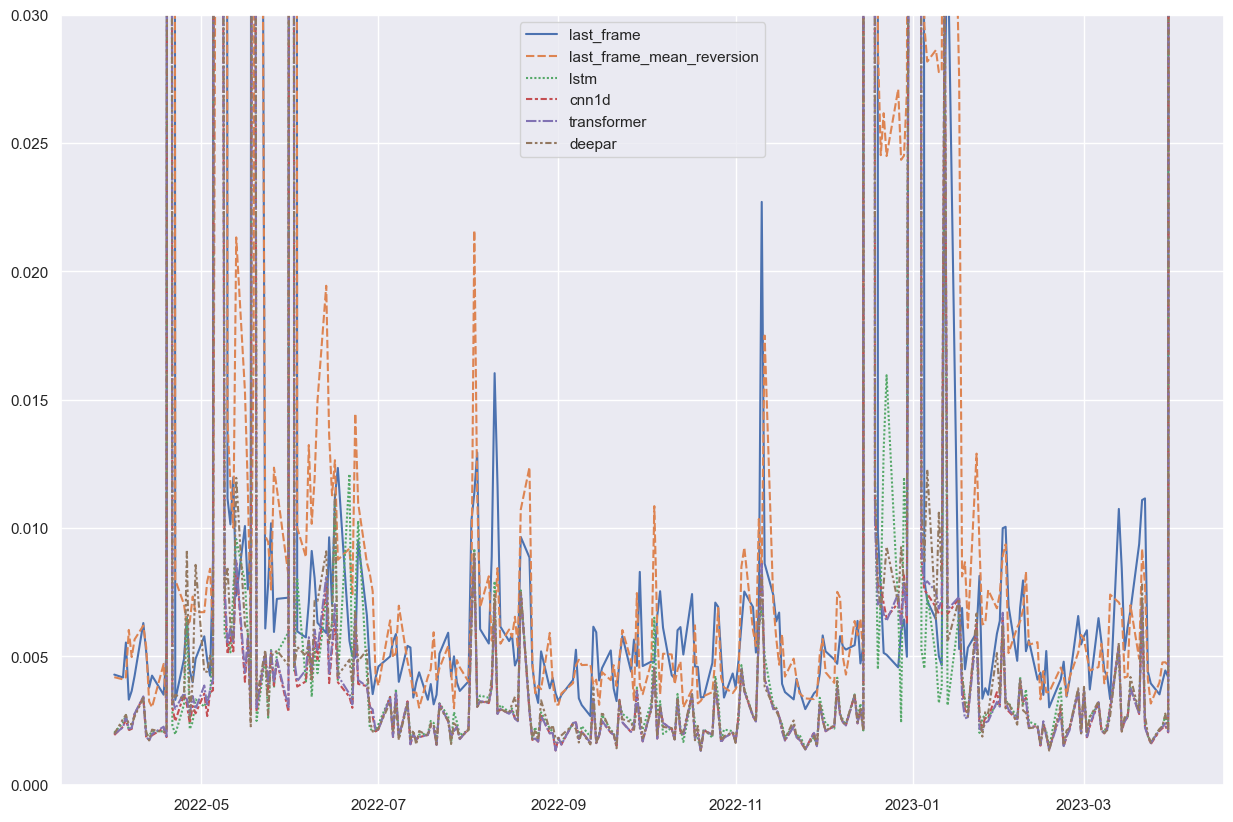

In [12]:
ax_test, mse_df_test = plot_mse(
    [
        y_pred_test_lf_real, y_pred_test_lfmr_real, y_pred_test_lstm_real, y_pred_test_cnn1d_real, 
        y_pred_test_transformer_real, y_pred_test_deepar_real
    ], y_test_real, 
    [
        'last_frame', 'last_frame_mean_reversion', 'lstm', 'cnn1d', 'transformer', 'deepar'
    ], 
    test_index
)

In [13]:
generate_report(
    [
        y_pred_test_lf_real, y_pred_test_lfmr_real, y_pred_test_lstm_real, y_pred_test_cnn1d_real, 
        y_pred_test_transformer_real, y_pred_test_deepar_real
    ], y_test_real, 
    [
        'last_frame', 'last_frame_mean_reversion', 'lstm', 'cnn1d', 'transformer', 'deepar'
    ]
)

,mse,corr,deviation
last_frame,0.032232,0.036621,1.303069
last_frame_mean_reversion,0.027019,0.053110,1.306428
lstm,0.015722,0.156977,1.095854
cnn1d,0.015252,0.215507,1.066732
transformer,0.015208,0.213857,1.066933
deepar,0.015325,0.176929,1.084690
